<div class="alert alert-danger">
    <h4 style="font-weight: bold; font-size: 28px;">Baseline Models</h4>
    <p style="font-size: 20px;">NBA API Data (1984-2024)</p>
</div>

<a name="Baseline Models"></a>

# Table of Contents

[Setup](#Setup)

[Data](#Data)

**[1. Target: Game Winner](#1.-Target:-Game-Winner)**
  
**[2. Target: Total Points (over / under)](#2.-Target:-Total-Points-(over-/-under))**

- [2.1. Setup](#2.1.-Setup)

- [2.2. Time Series Cross-Validation](#2.2.-Time-Series-Cross-Validation)

- [2.3. Manual Rolling Window](#2.3.-Manual-Rolling-Window)

**[3. Target: Difference in Points (plus / minus)](#3.-Target:-Difference-in-Points-(plus-/-minus))**

# Setup

[Return to top](#Baseline-Models)

In [100]:
# basic modules
import os
import time
import random as rn
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# plotting style
plt.style.use('seaborn-v0_8-notebook')
sns.set_style('white')
#sns.set_style('darkgrid')

# pandas tricks for better display
pd.options.display.max_columns = 50  
pd.options.display.max_rows = 500     
pd.options.display.max_colwidth = 100
pd.options.display.precision = 3

# preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, PolynomialFeatures
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

# sampling
from imblearn.over_sampling import RandomOverSampler, SMOTE, SMOTENC, ADASYN, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler, ClusterCentroids
 
# models
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import StackingClassifier

# metrics & utilities 
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, GridSearchCV, StratifiedKFold, TimeSeriesSplit
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay, auc
from sklearn.metrics import average_precision_score, precision_recall_curve, PrecisionRecallDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, mean_squared_error
from sklearn.utils import resample, class_weight

# variable importance
import shap
from shap.explainers import Tree
from lime.lime_tabular import LimeTabularExplainer
from sklearn.inspection import permutation_importance

# warnings
import warnings
warnings.filterwarnings("ignore")

# user defined functions
import utility_functions as utl

# Data

[Return to top](#Baseline-Models)

In [101]:
team_matchups_df = pd.read_csv('../data/processed/nba_team_matchups_1984_2024.csv')

# convert 'GAME_DATE' column to datetime
team_matchups_df['GAME_DATE'] = pd.to_datetime(team_matchups_df['GAME_DATE'])

In [102]:
team_matchups_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52083 entries, 0 to 52082
Data columns (total 54 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   SEASON_ID               52083 non-null  int64         
 1   HOME_TEAM_ID            52083 non-null  int64         
 2   HOME_TEAM_ABBREVIATION  52083 non-null  object        
 3   HOME_TEAM_NAME          52083 non-null  object        
 4   GAME_ID                 52083 non-null  int64         
 5   GAME_DATE               52083 non-null  datetime64[ns]
 6   HOME_WL                 52081 non-null  object        
 7   HOME_MIN                52083 non-null  int64         
 8   HOME_PTS                52083 non-null  int64         
 9   HOME_FGM                52083 non-null  int64         
 10  HOME_FGA                52083 non-null  int64         
 11  HOME_FG_PCT             52083 non-null  float64       
 12  HOME_FG3M               52083 non-null  int64 

In [103]:
team_matchups_df.head()

,SEASON_ID,HOME_TEAM_ID,HOME_TEAM_ABBREVIATION,HOME_TEAM_NAME,GAME_ID,GAME_DATE,HOME_WL,HOME_MIN,HOME_PTS,HOME_FGM,HOME_FGA,HOME_FG_PCT,HOME_FG3M,HOME_FG3A,HOME_FG3_PCT,HOME_FTM,HOME_FTA,HOME_FT_PCT,HOME_OREB,HOME_DREB,HOME_REB,HOME_AST,HOME_STL,HOME_BLK,HOME_TOV,...,AWAY_TEAM_NAME,AWAY_WL,AWAY_MIN,AWAY_PTS,AWAY_FGM,AWAY_FGA,AWAY_FG_PCT,AWAY_FG3M,AWAY_FG3A,AWAY_FG3_PCT,AWAY_FTM,AWAY_FTA,AWAY_FT_PCT,AWAY_OREB,AWAY_DREB,AWAY_REB,AWAY_AST,AWAY_STL,AWAY_BLK,AWAY_TOV,AWAY_PF,AWAY_PLUS_MINUS,TOTAL_PTS,HOME_PM,AWAY_PM
0,21983,1610612737,ATL,Atlanta Hawks,28300014,1983-10-29,W,240,117,49,94,0.521,0,1.0,0.0,19,30,0.633,27.0,21.0,48.0,28,14.0,7,23,...,Detroit Pistons,L,240,115,40,88,0.455,3,4.0,0.75,32,38,0.842,23.0,22.0,45.0,22,10.0,2,21,29,NaN,232,2,-2
1,21983,1610612737,ATL,Atlanta Hawks,28300027,1983-11-01,W,240,95,38,81,0.469,0,0.0,NaN,19,30,0.633,12.0,29.0,41.0,20,7.0,10,16,...,Washington Bullets,L,240,92,35,74,0.473,0,0.0,NaN,22,34,0.647,10.0,37.0,47.0,20,5.0,3,22,26,NaN,187,3,-3
2,21983,1610612737,ATL,Atlanta Hawks,28300041,1983-11-04,W,240,103,42,86,0.488,1,1.0,1.0,18,26,0.692,19.0,27.0,46.0,31,14.0,13,18,...,Chicago Bulls,L,240,90,30,80,0.375,0,3.0,0.00,30,41,0.732,25.0,28.0,53.0,13,6.0,3,26,25,NaN,193,13,-13
3,21983,1610612737,ATL,Atlanta Hawks,28300101,1983-11-15,W,240,107,45,84,0.536,0,0.0,NaN,17,21,0.810,17.0,24.0,41.0,24,7.0,10,18,...,San Diego Clippers,L,240,102,40,78,0.513,0,2.0,0.00,22,33,0.667,17.0,22.0,39.0,28,5.0,6,19,20,NaN,209,5,-5
4,21983,1610612737,ATL,Atlanta Hawks,28300112,1983-11-17,W,240,99,35,66,0.530,1,2.0,0.5,28,40,0.700,10.0,35.0,45.0,20,5.0,12,23,...,Philadelphia 76ers,L,240,94,35,87,0.402,2,5.0,0.40,22,27,0.815,16.0,24.0,40.0,17,7.0,5,16,32,NaN,193,5,-5


In [104]:
team_matchups_df.describe()

,SEASON_ID,HOME_TEAM_ID,GAME_ID,GAME_DATE,HOME_MIN,HOME_PTS,HOME_FGM,HOME_FGA,HOME_FG_PCT,HOME_FG3M,HOME_FG3A,HOME_FG3_PCT,HOME_FTM,HOME_FTA,HOME_FT_PCT,HOME_OREB,HOME_DREB,HOME_REB,HOME_AST,HOME_STL,HOME_BLK,HOME_TOV,HOME_PF,HOME_PLUS_MINUS,AWAY_TEAM_ID,AWAY_MIN,AWAY_PTS,AWAY_FGM,AWAY_FGA,AWAY_FG_PCT,AWAY_FG3M,AWAY_FG3A,AWAY_FG3_PCT,AWAY_FTM,AWAY_FTA,AWAY_FT_PCT,AWAY_OREB,AWAY_DREB,AWAY_REB,AWAY_AST,AWAY_STL,AWAY_BLK,AWAY_TOV,AWAY_PF,AWAY_PLUS_MINUS,TOTAL_PTS,HOME_PM,AWAY_PM
count,52083.000,5.208e+04,5.208e+04,52083,52083.000,52083.000,52083.000,52083.000,52083.000,52083.000,52082.000,51468.000,52083.000,52083.000,52083.000,52080.000,52080.000,52083.000,52083.000,52082.000,52083.000,52083.000,52083.000,37244.000,5.208e+04,52083.000,52083.000,52083.000,52083.000,52083.000,52083.000,52082.000,51664.000,52083.000,52083.000,52083.000,52082.000,52082.000,52083.000,52083.000,52082.000,52083.000,52083.000,52083.000,37244.000,52083.000,52083.000,52083.000
mean,22882.646,1.611e+09,5.769e+07,2005-02-10 02:14:42.115085696,240.494,103.711,38.871,83.508,0.466,6.291,17.681,0.343,19.677,25.999,0.757,12.096,31.266,43.364,23.646,7.979,5.301,14.396,21.616,2.820,1.611e+09,240.487,100.435,37.776,83.335,0.454,6.177,17.736,0.335,18.707,24.795,0.755,11.685,30.127,41.813,21.920,7.837,4.686,14.800,22.393,-2.821,204.146,3.276,-3.276
min,12003.000,1.611e+09,1.030e+07,1983-10-28 00:00:00,-1.000,36.000,12.000,29.000,0.217,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,15.000,4.000,0.000,0.000,1.000,5.000,-68.000,1.611e+09,0.000,33.000,9.000,31.000,0.239,0.000,0.000,0.000,1.000,1.000,0.143,0.000,0.000,3.000,2.000,0.000,0.000,2.000,5.000,-73.000,69.000,-68.000,-73.000
25%,21994.000,1.611e+09,2.090e+07,1995-03-31 12:00:00,240.000,94.000,35.000,78.000,0.425,3.000,10.000,0.256,15.000,20.000,0.696,9.000,27.000,39.000,20.000,6.000,3.000,11.000,18.000,-7.000,1.611e+09,240.000,91.000,34.000,77.000,0.415,3.000,10.000,0.250,14.000,19.000,0.692,9.000,26.000,37.000,18.000,6.000,3.000,12.000,19.000,-11.000,188.000,-6.000,-12.000
50%,22005.000,1.611e+09,2.200e+07,2005-12-27 00:00:00,240.000,103.000,39.000,83.000,0.465,6.000,16.000,0.345,19.000,25.000,0.763,12.000,31.000,43.000,23.000,8.000,5.000,14.000,21.000,4.000,1.611e+09,240.000,100.000,38.000,83.000,0.453,6.000,16.000,0.333,18.000,24.000,0.760,11.000,30.000,42.000,22.000,8.000,4.000,15.000,22.000,-4.000,203.000,4.000,-4.000
75%,22015.000,1.611e+09,2.920e+07,2015-01-02 00:00:00,240.000,113.000,43.000,89.000,0.506,9.000,24.000,0.429,24.000,31.000,0.825,15.000,35.000,48.000,27.000,10.000,7.000,17.000,25.000,11.000,1.611e+09,240.000,109.000,42.000,89.000,0.493,9.000,24.000,0.423,23.000,30.000,0.824,14.000,34.000,46.000,25.000,10.000,6.000,18.000,26.000,7.000,220.000,12.000,6.000
max,62023.000,1.611e+09,1.622e+09,2024-01-21 00:00:00,688.000,184.000,68.000,135.000,0.697,28.000,70.000,2.000,61.000,80.000,1.000,37.000,55.000,77.000,50.000,27.000,23.000,39.000,45.000,73.000,1.611e+09,450.000,186.000,74.000,136.000,0.687,29.000,69.000,2.000,52.000,64.000,1.000,38.000,60.000,81.000,52.000,24.000,20.000,40.000,52.000,68.000,370.000,73.000,68.000
std,5186.553,8.566e+00,2.179e+08,NaN,11.933,14.021,6.106,8.752,0.059,4.471,10.746,0.156,6.793,8.416,0.099,4.432,5.651,6.870,5.731,3.098,2.758,4.150,4.725,13.417,8.571e+00,11.774,13.618,5.839,8.767,0.057,4.378,10.632,0.151,6.414,7.941,0.101,4.266,5.609,6.659,5.411,3.015,2.509,4.323,4.967,13.414,24.218,13.326,13.326


<a name="1.-Target:-Game-Winner"></a>
# 1. Target: Game Winner

[Return to top](#Baseline-Models)

<a name="2.-Target:-Total-Points-(over-/-under)"></a>
# 2. Target: Total Points (over / under)

[Return to top](#Baseline-Models)

<a name="2.1.-Setup"></a>
## 2.1. Setup

[Return to top](#Baseline-Models)

In [125]:
# filter data to about 1 year
team_matchups_2023 = team_matchups_df[team_matchups_df['GAME_DATE'] >= '2023-01-01']

# non-feature columns
omit_cols = [
  'SEASON_ID', 'HOME_TEAM_ID', 'HOME_TEAM_ABBREVIATION', 'HOME_TEAM_NAME',
  'GAME_ID', 'GAME_DATE', 'HOME_WL', 'AWAY_TEAM_ID', 'AWAY_TEAM_ABBREVIATION',
  'AWAY_TEAM_NAME', 'AWAY_WL'
]

# drop non-features
team_matchups_2023_subset = team_matchups_2023.drop(omit_cols, axis=1)

# get all features excluding the target
features = team_matchups_2023_subset.drop('TOTAL_PTS', axis=1) 

# get column names
all_colnames = features.columns.tolist()
all_colnames.append('TOTAL_PTS')

# get target
target = team_matchups_2023_subset['TOTAL_PTS']  

# min-max scaling for features
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)

# recombine scaled features with the target
scaled_data = np.concatenate([scaled_features, target.values.reshape(-1, 1)], axis=1)

# convert scaled data back to DataFrame and reset index
scaled_data_df = pd.DataFrame(scaled_data)
scaled_data_df.columns = all_colnames
scaled_data_df = scaled_data_df.reset_index(drop=True)

In [126]:
scaled_data_df.head()

,HOME_MIN,HOME_PTS,HOME_FGM,HOME_FGA,HOME_FG_PCT,HOME_FG3M,HOME_FG3A,HOME_FG3_PCT,HOME_FTM,HOME_FTA,HOME_FT_PCT,HOME_OREB,HOME_DREB,HOME_REB,HOME_AST,HOME_STL,HOME_BLK,HOME_TOV,HOME_PF,HOME_PLUS_MINUS,AWAY_MIN,AWAY_PTS,AWAY_FGM,AWAY_FGA,AWAY_FG_PCT,AWAY_FG3M,AWAY_FG3A,AWAY_FG3_PCT,AWAY_FTM,AWAY_FTA,AWAY_FT_PCT,AWAY_OREB,AWAY_DREB,AWAY_REB,AWAY_AST,AWAY_STL,AWAY_BLK,AWAY_TOV,AWAY_PF,AWAY_PLUS_MINUS,HOME_PM,AWAY_PM,TOTAL_PTS
0,0.825,0.340,0.417,0.477,0.415,0.375,0.383,0.474,0.317,0.292,0.811,0.192,0.528,0.364,0.359,0.222,0.176,0.357,0.16,0.398,0.441,0.426,0.524,0.686,0.462,0.64,0.762,0.542,0.114,0.191,0.342,0.481,0.614,0.667,0.486,0.273,0.235,0.269,0.250,0.602,0.398,0.602,219.0
1,0.825,0.491,0.583,0.308,0.836,0.458,0.319,0.697,0.366,0.375,0.690,0.038,0.278,0.068,0.410,0.444,0.294,0.536,0.36,0.542,0.452,0.417,0.476,0.510,0.523,0.24,0.357,0.322,0.486,0.383,0.928,0.407,0.295,0.333,0.541,0.455,0.235,0.423,0.500,0.458,0.542,0.458,234.0
2,0.822,0.660,0.889,0.677,0.743,0.458,0.468,0.503,0.268,0.250,0.787,0.500,0.250,0.318,0.410,0.278,0.235,0.214,0.32,0.602,0.441,0.519,0.619,0.392,0.794,0.44,0.333,0.652,0.314,0.319,0.660,0.296,0.205,0.188,0.459,0.227,0.176,0.346,0.250,0.398,0.602,0.398,263.0
3,0.825,0.462,0.583,0.415,0.690,0.375,0.277,0.616,0.341,0.333,0.745,0.192,0.500,0.341,0.333,0.222,0.235,0.536,0.48,0.441,0.441,0.500,0.524,0.510,0.581,0.44,0.429,0.556,0.486,0.426,0.803,0.185,0.318,0.229,0.486,0.500,0.118,0.346,0.357,0.559,0.441,0.559,240.0
4,0.825,0.415,0.583,0.600,0.491,0.208,0.319,0.262,0.317,0.333,0.660,0.538,0.444,0.500,0.333,0.611,0.118,0.250,0.40,0.415,0.462,0.481,0.452,0.333,0.629,0.68,0.548,0.753,0.429,0.362,0.848,0.185,0.341,0.250,0.405,0.227,0.294,0.423,0.250,0.585,0.415,0.585,233.0


<a name="2.2.-Time-Series-Cross-Validation"></a>
## 2.2. Time Series Cross-Validation

[Return to top](#Baseline-Models)

In [127]:
# feature columns
X = scaled_data_df.drop('TOTAL_PTS', axis=1)

# target column
y = scaled_data_df['TOTAL_PTS']

In [128]:
# initialize TimeSeriesSplit
# n_splits = 12 # roughly monthly
n_splits = len(X) - 1 # LOO
tscv = TimeSeriesSplit(n_splits=n_splits)

# initialize model
glm = LinearRegression()

# storage for predictions and MSE
predictions = []
mse_scores = []

start_time = time.time()

# iterate over each time split
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # fit model on training data and predict on test data
    glm.fit(X_train, y_train)
    prediction = glm.predict(X_test)
    predictions.append(prediction[0])
    
    # evaluate model
    mse = mean_squared_error(y_test, prediction)
    mse_scores.append(mse)

# get average MSE over all splits
average_mse = sum(mse_scores) / len(mse_scores)
print(f"Average Mean Squared Error: {average_mse}")

end_time = time.time()
total_time = end_time - start_time
print(f"Total time taken: {total_time} seconds")

Average Mean Squared Error: 2.4303364309129423
Total time taken: 5.539905071258545 seconds


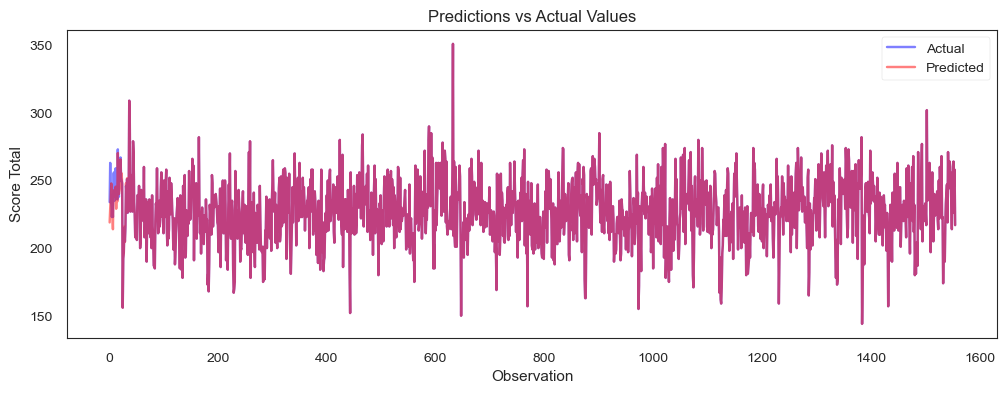

In [129]:
# get observations
observed_values = y.iloc[1:]

# plot
plt.figure(figsize=(12, 4))
plt.plot(observed_values.index, observed_values, label='Actual', color='blue', alpha=0.5)
plt.plot(observed_values.index, predictions, label='Predicted', color='red', alpha=0.5)
plt.title('Predictions vs Actual Values')
plt.xlabel('Observation')
plt.ylabel('Score Total')
plt.legend();

<a name="2.3.-Manual-Rolling-Window"></a>
## 2.3. Manual Rolling Window

[Return to top](#Baseline-Models)

In [130]:
start_time = time.time()

# define window size
window_size = 30 

# storage for predictions
predictions = []

# rolling window loop
for start_index in range(len(scaled_data) - window_size):
    end_index = start_index + window_size

    # training data for this window
    X_train = scaled_data[start_index:end_index, :-1]  # all features, excluding target
    y_train = scaled_data[start_index:end_index, -1]   # target feature

    # next observation to predict
    X_next = scaled_data[end_index, :-1].reshape(1, -1)  # reshape for single prediction

    # train the linear model
    glm = LinearRegression()
    glm.fit(X_train, y_train)

    # Predict the next value and store the prediction
    prediction = glm.predict(X_next)
    predictions.append(prediction[0])

end_time = time.time()
total_time = end_time - start_time
print(f"Total time taken: {total_time} seconds")

Total time taken: 0.3914048671722412 seconds


In [ ]:
# aligning the start of predictions with the actual values
# The first prediction corresponds to the observation at index window_size
observed_values = scaled_data_df['TOTAL_PTS'][window_size:]

# ensure that 'predictions' and 'actual_values' have the same length
# this is necessary because the last few values of df['score_total'] won't have corresponding predictions
predictions_aligned = predictions[:len(actual_values)]

# plot
plt.figure(figsize=(12, 4))
plt.plot(observed_values.index, observed_values, label='Actual', color='blue', alpha=0.5)
plt.plot(observed_values.index, predictions_aligned, label='Predicted', color='red', alpha=0.5)
plt.title('Predictions vs Actual Values')
plt.xlabel('Observation')
plt.ylabel('Score Total')
plt.legend();

<a name="3.-Target:-Difference-in-Points-(plus-/-minus)"></a>
# 3. Target: Difference in Points (plus / minus)

[Return to top](#Baseline-Models)